In [1]:
%load_ext autoreload
%autoreload 2

# Import Modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy.optimize import linear_sum_assignment
import scipy.optimize
import scipy.io
from tqdm import tqdm
import os
from Tracking import *
from hist3d import *
import warnings

In [3]:
warnings.filterwarnings('ignore')

# Load corrected data

In [4]:
f1 = '10G0502'
f2 = '10G2603'
d1 = np.loadtxt('sample_data/10G0502.C.txt')
d2 = np.loadtxt('sample_data/10G2603.C.txt')
#d2 = np.loadtxt('/home/ashwin/Documents/Schooling_Fish/package/git_hub/pyFish/data/guys_data/tracked_and_corrected/10/corrected_mod/10G2603_corrected_mod.txt')

n_fish = 10
t_int = 1/25

xc1, yc1 = d1.T
xc1 = xc1.reshape((len(xc1)//n_fish, n_fish))
yc1 = yc1.reshape((len(yc1)//n_fish, n_fish))

xc2, yc2 = d2.T
xc2 = xc2.reshape((len(xc2)//n_fish, n_fish))
yc2 = yc2.reshape((len(yc2)//n_fish, n_fish))

# Idle fish
> ## Plot the frequency of fish not in motion

In [5]:
def get_vel(x,y, t_int=t_int):
    vel_x = np.diff(x.round(), axis=0)/t_int
    vel_y = np.diff(y.round(), axis=0)/t_int
    return np.sqrt(vel_x**2 + vel_y**2)

def mean_pol(x,y,t_int=t_int):
    vel_x = np.diff(x.round(), axis=0)/t_int
    vel_y = np.diff(y.round(), axis=0)/t_int
    vel = np.sqrt(vel_x**2 + vel_y**2)
    mx = vel_x/vel
    mx[np.isnan(mx)] = 0
    my = vel_y/vel
    my[np.isnan(my)] = 0
    Mx = np.mean(mx, axis=1)
    My = np.mean(my, axis=1)
    M = np.sqrt(Mx**2 + My**2)
    return M.mean().round(3)

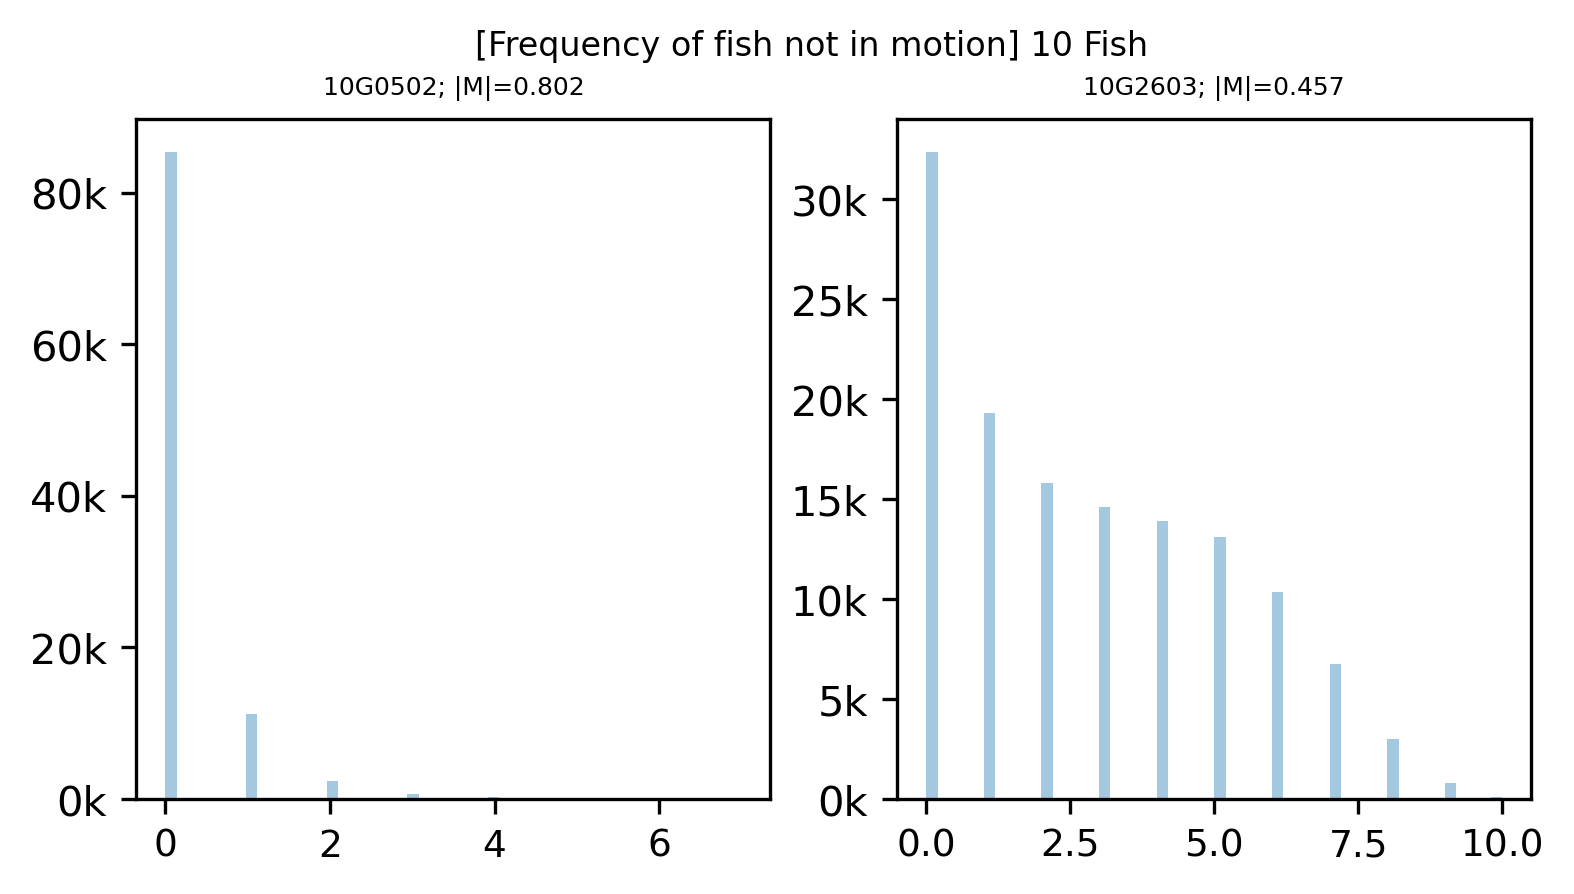

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=300)
fig.suptitle('[Frequency of fish not in motion] 10 Fish', fontsize=8)
fmt = lambda x, pos: '{}k'.format(int(x//1e3), pos)
n_fish_moving = np.count_nonzero(get_vel(xc1,yc1), axis=1)
sns.distplot(n_fish - n_fish_moving, kde=False, ax=ax[0])
ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(fmt))
ax[0].yaxis.set_tick_params(labelsize=10)
ax[0].xaxis.set_tick_params(labelsize=9)
ax[0].set_title("{}; |M|={}".format(f1, mean_pol(xc1,yc1)), fontsize=6, color='black')

n_fish_moving = np.count_nonzero(get_vel(xc2,yc2), axis=1)
sns.distplot(n_fish - n_fish_moving, kde=False, ax=ax[1])
ax[1].yaxis.set_major_formatter(ticker.FuncFormatter(fmt))
ax[1].yaxis.set_tick_params(labelsize=10)
ax[1].xaxis.set_tick_params(labelsize=9)
ax[1].set_title("{}; |M|={}".format(f2, mean_pol(xc2,yc2)), fontsize=6, color='black')
plt.show()

> ## From the above chart, the low polorised file has several idle fish, thus effecting the group behaviour dynamics

> ## <span style="color:green">To correct this issue, consider only the frames where atleast 8 fish are in motion.</span>

# Tracked and corrected + 8 or more fish moving

In [7]:
def pol2(x,y,t_int=(1/25)):
    vel_x = np.diff(x.round(), axis=0)/t_int
    vel_y = np.diff(y.round(), axis=0)/t_int
    vel = np.sqrt(vel_x**2 + vel_y**2)+1e-20
    mx = vel_x/vel
    my = vel_y/vel
    Mx = np.mean(mx, axis=1)
    My = np.mean(my, axis=1)
    M = np.sqrt(Mx**2 + My**2)
    return Mx, My, M

def cut_data(x,y,f_th=10):
    n_fish_moving = np.count_nonzero(get_vel(x,y), axis=1)
    mask = np.where(n_fish_moving < f_th)
    x_ = x.copy()
    y_ = y.copy()
    x_[mask] = np.nan
    y_[mask] = np.nan
    return pol2(x_, y_)

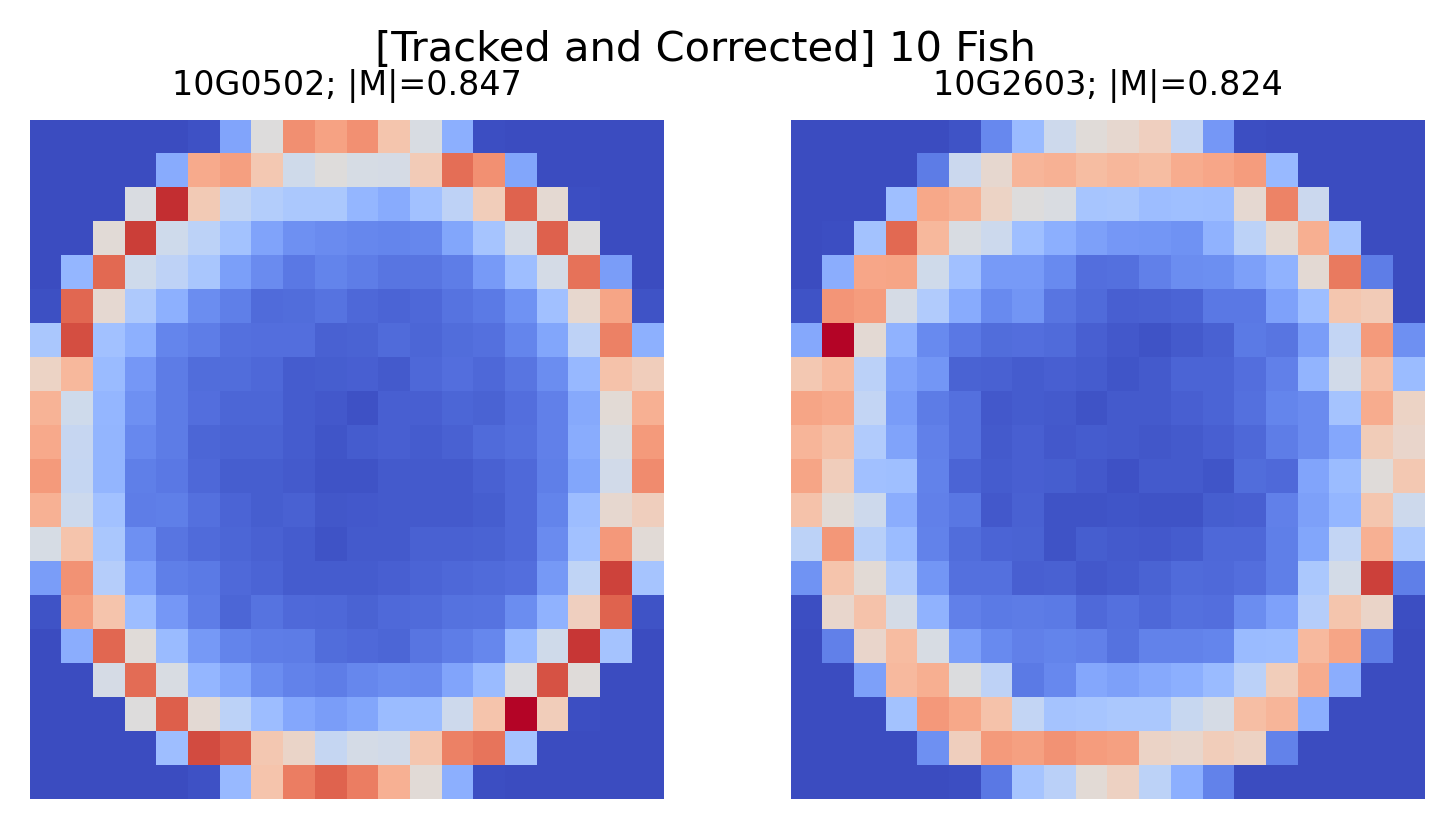

In [8]:
f_th=10
Mx1, My1, M1 = cut_data(xc1, yc1, f_th=f_th)
fig, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=300)
fig.suptitle('[Tracked and Corrected] 10 Fish', fontsize=10)
H, edges, X, Y, Z, dx, dy, dz = histogram_3d(np.array([Mx1[~np.isnan(Mx1)], My1[~np.isnan(My1)]]))
bin_count = int(np.sqrt(len(dz)))
dz = dz.reshape((bin_count, bin_count))
ax[0].xaxis.set_major_locator(plt.NullLocator())
ax[0].yaxis.set_major_locator(plt.NullLocator())
sns.heatmap(dz,xticklabels=[], yticklabels=[],cmap=plt.cm.coolwarm,cbar=False, ax=ax[0])
M = np.nanmean(M1).round(3)
ax[0].set_title("{}; |M|={}".format(f1, M), fontsize=8)

Mx2, My2, M2 = cut_data(xc2, yc2, f_th=f_th)
H, edges, X, Y, Z, dx, dy, dz = histogram_3d(np.array([Mx2[~np.isnan(Mx2)], My2[~np.isnan(My2)]]))
bin_count = int(np.sqrt(len(dz)))
dz = dz.reshape((bin_count, bin_count))
ax[1].xaxis.set_major_locator(plt.NullLocator())
ax[1].yaxis.set_major_locator(plt.NullLocator())
sns.heatmap(dz,xticklabels=[], yticklabels=[],cmap=plt.cm.coolwarm,cbar=False, ax=ax[1])
M = np.nanmean(M2).round(3)
ax[1].set_title("{}; |M|={}".format(f2, M), fontsize=8)
plt.show()